# Redefining a faster connectivity tensor

## Upshot
- Long story short refer to the function `ScRRAMBLe_routing_under_construction2()`
- It is now part of utils under `fast_scrramble.py`

In [2]:
import jax
import math
import jax.numpy as jnp
import optax
import flax
from flax import nnx
from flax.nnx.nn import initializers
from typing import Callable
import json
import os
import pickle
import numpy as np
from collections import defaultdict
from functools import partial
from tqdm import tqdm
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

# from models import ScRRAMBLeCapsLayer

from utils.activation_functions import quantized_relu_ste, squash
from utils import intercore_connectivity, load_and_augment_mnist
from utils import ScRRAMBLe_routing
import timeit


import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.

2025-08-22 12:00:35.712177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755889235.724968 1116478 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755889235.728764 1116478 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Max beta = 46
Unique weights in C: [0. 1. 2. 3.]
Weight 1.0
#Weight 1.0: 8335
Adding negative connections for weight 1.0, iteration 1
Weight 2.0
#Weight 2.0: 723
Adding negative connections for weight 2.0, iteration 1
Adding negative connections for weight 2.0, iteration 2
Weight 3.0
#Weight 3.0: 45
Adding negative connections for weight 3.0, iteration 1
Adding negative connections for weight 3.0, iteration 2
Adding negative connections for weight 3.0, iteration 3
[23, 27, 17, 23, 30, 13, 26, 37, 21, 12] (Array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),)


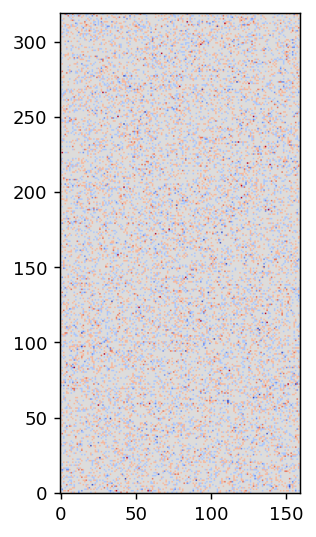

In [ ]:
## ScRRAMBLe with JAX. Construct from the perspective of source slots -> destination slots.
def ScRRAMBLe_routing_under_construction(
    num_destination_cores = 10,
    num_source_cores = 20,
    core_size = 256,
    slot_size = 16,
    key = jax.random.key(0),
    proba = 0.2,
    verify_balanced_flag=True,
):
    """
    ScRRAMBLe Routing.
    Logic:
    - Define an empty tensor Cijkl with indices source core ci, source slot si, destination core cj, destination slot sj.
    - For every (ci, si) pick a binomial random sample beta with probability p, n = number of total destination slots.
    - Select b destination slots, randomly.
    - In Cijkl add 1 to the corresponding indices (ci, si, cj, sj).
    - For balancing, simply shuffle the final dimention of Cijkl. (along sj)
    - Add -1 to the new shuffled indices
    """

    slots_per_core = core_size // slot_size

    # initialize the connectivity matrix C
    C = jnp.zeros((num_source_cores, slots_per_core, num_destination_cores, slots_per_core))

    # ----------------------
    # Positive Connections
    # ----------------------

    # pick beta values for connections
    key, subkey = jax.random.split(key)
    betas = jax.random.binomial(key=key, n=num_destination_cores*slots_per_core, p=proba, shape=(num_source_cores, slots_per_core))
    max_beta = jnp.max(betas)
    max_beta = int(max_beta)
    print(f"Max beta = {max_beta}")

    # create a mask for connections
    mask = jnp.arange(max_beta)[None, None, :] < betas[:, :, None]
    ci_idx, si_idx, beta_idx = jnp.where(mask)

    # generate random destination locations
    key, subkey = jax.random.split(subkey)
    destination_core_indices = jax.random.choice(key=key, a=num_destination_cores, shape=(num_source_cores, slots_per_core, max_beta), replace=True)
    key, subkey = jax.random.split(subkey)
    destination_slot_indices = jax.random.choice(key=key, a=slots_per_core, shape=(num_source_cores, slots_per_core, max_beta), replace=True)

    # find the indices of the destination locations
    cj_idx = destination_core_indices[ci_idx, si_idx, beta_idx]
    # print(cj_idx)
    sj_idx = destination_slot_indices[ci_idx, si_idx, beta_idx]
    # print(sj_idx, sj_idx.shape)

    # add positive connections
    C = C.at[ci_idx, si_idx, cj_idx, sj_idx].add(1)

    # ----------------------
    # Negative connections
    # ----------------------

    # find the values inside C
    unique_weights = jnp.unique(C)
    print(f"Unique weights in C: {unique_weights}")

    for iw, w in enumerate(unique_weights):
        if w > 0:
            print(f"Weight {w}")
            ci_idx_pos, si_idx_pos, cj_idx_pos, sj_idx_pos = jnp.where(C == w)
            print(f"#Weight {w}: {ci_idx_pos.shape[0]}")

            # pick shuffle indices
            for i in range(1, int(w + 1)):
                print(f"Adding negative connections for weight {w}, iteration {i}")
                key, subkey = jax.random.split(key)
                sj_idx_neg = jax.random.choice(key=key, a=slots_per_core, shape=(sj_idx_pos.shape[0], ), replace=True)
                C = C.at[ci_idx_pos, si_idx_pos, cj_idx_pos, sj_idx_neg].add(-1)

    # check the unique weights again
    sums_ = []
    for i in range(C.shape[2]):
        sums_.append(int(jnp.sum(C[:, :, i, :])))

    print(sums_, jnp.where(jnp.array(sums_) > 0))
        





    

    # # find the indices where C > 0
    # ci_idx_pos, si_idx_pos, cj_idx_pos, sj_idx_pos = jnp.where(C > 0)

    # # shuffle the sj indices
    # key, subkey = jax.random.split(key)
    # sj_idx_neg = jax.random.choice(key=key, a=slots_per_core, shape=(sj_idx_pos.shape[0], ), replace=True)

    # # add the negative connections
    # C = C.at[ci_idx_pos, si_idx_pos, cj_idx_pos, sj_idx_neg].add(-1)

    # verify balanced condition
    def verify_balanced_connectivity(C):
        """
        Verify if the connectivity matrix makes sense
        - Each core must have equal number of positive and negative connections on an average
        - Returs a distribution of connections per core.
        - Distribution should be a delta zero with ideally no outliers.
        """
        
        assert C.ndim == 4, "C must be a 4D tensor"

        # keep a tally of sums
        # sums_list = []

        # for ci in range(C.shape[0]):
        #     for si in range(C.shape[1]):
        #         for co in range(C.shape[2]):
        #             sum_ = jnp.sum(C[ci, si, co, :])
        #             sums_list.append(int(sum_))

        # print(sums_list)

        # print(C[0, 2, 0, :])
        # print(jnp.sum(C[0, 2, 0, :]))
                    
        for i in range(C.shape[0]):
            # print(C[i, :, :, :].shape)
            print(C[:, :, i, :])
            sum_ = jnp.sum(C[:, :, i, :])
            # sums_list.append(int(sum_))

        print(sum_)

        # perc = jnp.percentile(jnp.array(sums_list), q=90)

        # if perc == 0:
        #     pass
        # else:
        #     raise ValueError(f"Connectivity matrix is not balanced. 95th percentile is {perc}")
        
    # if verify_balanced_flag:
    #     verify_balanced_connectivity(C)


    return C




C = ScRRAMBLe_routing_under_construction()

fig, ax = plt.subplots(dpi=130)
im = ax.imshow(C.reshape((C.shape[0] * C.shape[1], C.shape[2] * C.shape[3])), cmap='coolwarm', vmax=3, vmin=-3, origin='lower')



Max beta = 829


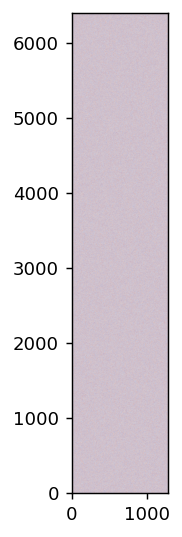

In [4]:
## ScRRAMBLe with JAX. Construct from the perspective of source slots -> destination slots.
def ScRRAMBLe_routing_under_construction2(
    num_destination_cores = 10,
    num_source_cores = 50,
    core_size = 256,
    slot_size = 2,
    key = jax.random.key(0),
    proba = 0.6,
    verify_balanced_flag=True,
):
    """
    ScRRAMBLe Routing.
    Logic:
    - Define an empty tensor Cijkl with indices source core ci, source slot si, destination core cj, destination slot sj.
    - For every (ci, si) pick a binomial random sample beta with probability p, n = number of total destination slots.
    - Select b destination slots, randomly.
    - In Cijkl add 1 to the corresponding indices (ci, si, cj, sj).
    - For balancing, simply shuffle the final dimention of Cijkl. (along sj)
    - Add -1 to the new shuffled indices
    """

    slots_per_core = core_size // slot_size

    # initialize the connectivity matrix C
    C = jnp.zeros((num_source_cores, slots_per_core, num_destination_cores, slots_per_core))

    # ----------------------
    # Positive Connections
    # ----------------------

    # pick beta values for connections
    key, subkey = jax.random.split(key)
    betas = jax.random.binomial(key=key, n=num_destination_cores*slots_per_core, p=proba, shape=(num_source_cores, slots_per_core))
    max_beta = jnp.max(betas)
    max_beta = int(max_beta)
    print(f"Max beta = {max_beta}")

    # create a mask for connections
    mask = jnp.arange(max_beta)[None, None, :] < betas[:, :, None]
    ci_idx, si_idx, beta_idx = jnp.where(mask)

    # generate random destination locations
    key, subkey = jax.random.split(subkey)
    destination_core_indices = jax.random.choice(key=key, a=num_destination_cores, shape=(num_source_cores, slots_per_core, max_beta), replace=True)
    key, subkey = jax.random.split(subkey)
    destination_slot_indices = jax.random.choice(key=key, a=slots_per_core, shape=(num_source_cores, slots_per_core, max_beta), replace=True)

    # find the indices of the destination locations
    cj_idx = destination_core_indices[ci_idx, si_idx, beta_idx]
    # print(cj_idx)
    sj_idx = destination_slot_indices[ci_idx, si_idx, beta_idx]
    # print(sj_idx, sj_idx.shape)

    # add positive connections
    C = C.at[ci_idx, si_idx, cj_idx, sj_idx].add(1)

    # ----------------------
    # Negative connections
    # ----------------------

    # find all positive connections and their weights
    ci_pos, si_pos, cj_pos, sj_pos = jnp.where(C > 0)
    weights = C[ci_pos, si_pos, cj_pos, sj_pos]
    # print(weights, weights.shape)

    # create repeats of connections the same number of times as the weights
    ci_neg_all = jnp.repeat(ci_pos, weights.astype(int))
    si_neg_all = jnp.repeat(si_pos, weights.astype(int))
    cj_neg_all = jnp.repeat(cj_pos, weights.astype(int))

    # total negative connections required
    total_neg_connections = jnp.sum(weights)

    # generate random destination slots for all negative connections
    key, subkey = jax.random.split(key)
    sj_neg_all = jax.random.choice(key=key, a=slots_per_core, shape=cj_neg_all.shape , replace=True) # shape=(int(total_neg_connections), )

    C = C.at[ci_neg_all, si_neg_all, cj_neg_all, sj_neg_all].add(-1)



    # find the values inside C
    # unique_weights = jnp.unique(C)
    # print(f"Unique weights in C: {unique_weights}")

    # for iw, w in enumerate(unique_weights):
    #     if w > 0:
    #         print(f"Weight {w}")
    #         ci_idx_pos, si_idx_pos, cj_idx_pos, sj_idx_pos = jnp.where(C == w)
    #         print(f"#Weight {w}: {ci_idx_pos.shape[0]}")

    #         # pick shuffle indices
    #         for i in range(1, int(w + 1)):
    #             print(f"Adding negative connections for weight {w}, iteration {i}")
    #             key, subkey = jax.random.split(key)
    #             sj_idx_neg = jax.random.choice(key=key, a=slots_per_core, shape=(sj_idx_pos.shape[0], ), replace=True)
    #             C = C.at[ci_idx_pos, si_idx_pos, cj_idx_pos, sj_idx_neg].add(-1)

    # # check the unique weights again
    # sums_ = []
    # for i in range(C.shape[2]):
    #     sums_.append(int(jnp.sum(C[:, :, i, :])))

    # print(sums_, jnp.where(jnp.array(sums_) > 0))
        





    

    # # find the indices where C > 0
    # ci_idx_pos, si_idx_pos, cj_idx_pos, sj_idx_pos = jnp.where(C > 0)

    # # shuffle the sj indices
    # key, subkey = jax.random.split(key)
    # sj_idx_neg = jax.random.choice(key=key, a=slots_per_core, shape=(sj_idx_pos.shape[0], ), replace=True)

    # # add the negative connections
    # C = C.at[ci_idx_pos, si_idx_pos, cj_idx_pos, sj_idx_neg].add(-1)

    def verify_balanced_connectivity(C):
        """
        Verify if the connectivity matrix makes sense
        - Each core must have equal number of positive and negative connections on an average
        - Returs a distribution of connections per core.
        - Distribution should be a delta zero with ideally no outliers
        """

        assert len(C.shape) == 4, "C must be a 4D tensor"

        balance_list = []

        # check for cores taking inputs
        for co in range(C.shape[2]):
            conn = jnp.sum(C[:, :, co, :])
            balance_list.append(conn)

        perc = jnp.percentile(a=jnp.array(balance_list), q=95)
        if perc == 0:
            pass
        else:
            raise ValueError(f"Connectivity matrix is not balanced. 95th percentile is {perc}")

    if verify_balanced_flag:
        verify_balanced_connectivity(C)


    return C




C = ScRRAMBLe_routing_under_construction2()

fig, ax = plt.subplots(dpi=130)
im = ax.imshow(C.reshape((C.shape[0] * C.shape[1], C.shape[2] * C.shape[3])), cmap='coolwarm', vmax=3, vmin=-3, origin='lower')

del C

In [33]:
aa = jnp.array([3, 4, 6, 5, 5, 4, 3, 2, 2, 2])
uu = jnp.unique(aa)
uu

Array([2, 3, 4, 5, 6], dtype=int32)

[[31 41 47 ... 37  4 57]
 [26 55 34 ... 73 54 55]
 [32 76 72 ... 32 39 79]
 ...
 [52 21 70 ... 59 77 33]
 [75 30 72 ... 13 77 30]
 [70 41 22 ... 70 59 19]] (40, 30)


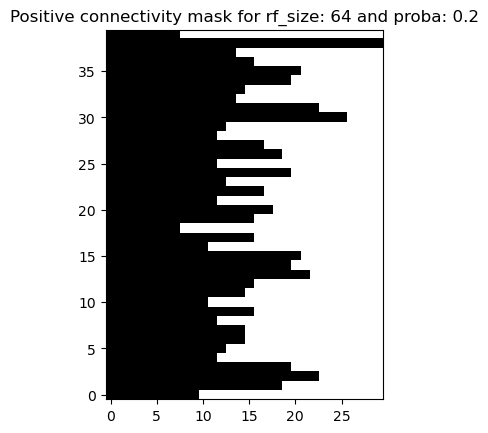

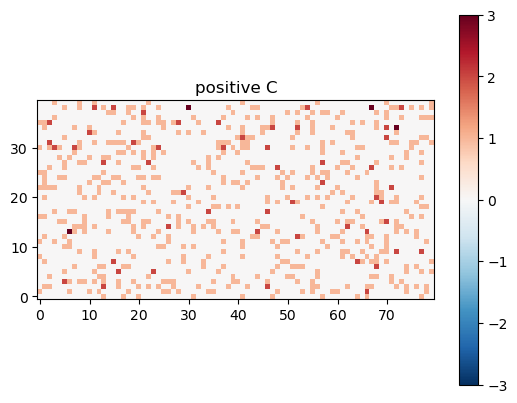

(10, 4, 20, 4)
max_c: 3
i = 3
No. of entries > 3, 0
i = 2
No. of entries > 2, 4
i = 1
No. of entries > 1, 55
[[[ 0.  0.  0.  0.]
  [ 0. -1.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  1.  0.  0.]
  [ 0.  1.  0.  0.]
  [ 1.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  1.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  1.  0.  0.]
  [ 0.  0.  0.  1.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  1.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 1.  0.  1.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  1.  0.  0.]]

 [[ 1.  0.  0.  0.]
  [ 0.  0.  1.  0.]
  [ 0.  0.  1.  0.]
  [ 1.  0.  0.  0.]
  [ 0.  0.  1.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  1.  1.  0.]
  [ 1.  0.  0.  0.]
  [ 0.  0.  1.  1.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0. -1.  0.]
  [ 1.  0.  0.  0.]
  [ 0.  1.  0.  1.]
  [ 0.  0.  0.  1.]
  [ 1.  0.  0.  0.]
  [ 0.  0.  2.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  1.  0.]
  [ 0.  0.  1.  0.]]

 [[ 0.  1.  1.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  2.  0.  0.]
  [ 1. 

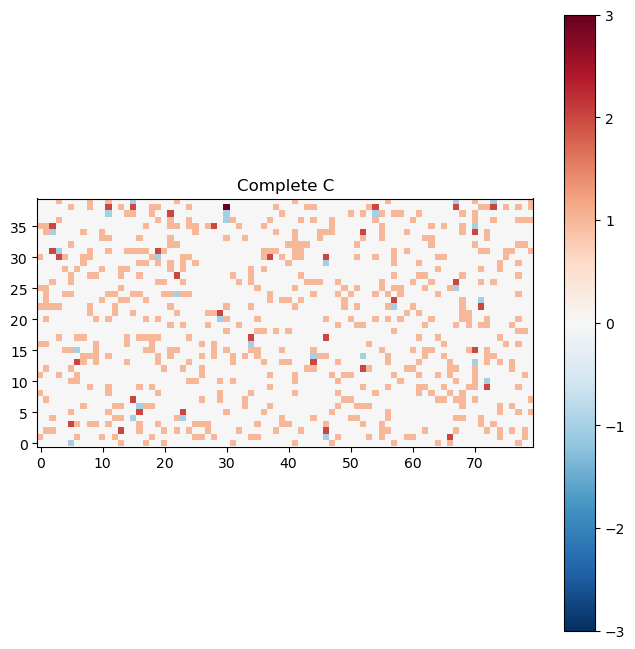

In [ ]:
## ScRRAMBLe with only JAX
def under_construction():
    num_output_cores = 10
    num_input_cores = 20
    core_size = 256
    rf_size = 64
    rfs_per_core = core_size // rf_size
    key = jax.random.key(0)
    proba = 0.2
    verify_balanced_flag=True

    # start with a 2D array
    C = jnp.zeros((num_output_cores*rfs_per_core, num_input_cores*rfs_per_core))

    # pick betas for positive connections
    betas = jax.random.binomial(key, n=C.shape[1], p=proba, shape=C.shape[0]) # n controls input size slots to be picked, p controls probability of picking a slot

    # create a mask for positive connections
    max_beta = jnp.max(betas)
    mask = jnp.arange(max_beta)[None, :] < betas[:, None]  # create a mask for the connections

    # extract row and column coordinates of valid connections
    row_idx, col_idx= jnp.where(mask)

    # pre-generate indices as if all rows and columns were connected but at random till maximum beta
    key, subkey = jax.random.split(key)

    # all_conn is a 2D array where each row contains indices of input connections for each output core
    all_conn = jax.random.choice(key, a=C.shape[1], shape=(C.shape[0], int(max_beta)))
    print(all_conn, all_conn.shape)

    # select the indices for connection
    sel_idx = all_conn[row_idx, col_idx]

    # create the connectivity matrix C
    C = C.at[row_idx, sel_idx].add(1)

    plt.figure()
    plt.imshow(mask, cmap='Greys', origin='lower')
    plt.title(f"Positive connectivity mask for rf_size: {rf_size} and proba: {proba}")

    plt.figure()
    plt.imshow(C, cmap='RdBu_r', origin='lower', vmax=3, vmin=-3)
    plt.title(f"positive C")
    plt.colorbar()
    plt.show()


    # ---
    # NEGATIVE CONNECTIONS
    # ---

    C = C.reshape(num_output_cores, rfs_per_core, num_input_cores, rfs_per_core)
    print(C.shape)

    # find the maximum entry in C
    max_c = int(jnp.max(C))
    print(f"max_c: {max_c}")

    for i in range(max_c, -1, -1):

        print(f"i = {i}")

        # pick core-slot indices where positive connections are present
        out_core_idx, out_slot_idx, in_core_idx, in_slot_idx = jnp.where(C > i)
        print(f"No. of entries > {i}, {out_core_idx.shape[0]}")


    # print(out_core_idx[:20], '\n',  out_slot_idx[:20], '\n', in_core_idx[:20], '\n', in_slot_idx[:20])

        # randomly permute the indices to create negative connections
        key, subkey = jax.random.split(key)
        permuted_out_slot_idx = jax.random.choice(key, a=rfs_per_core, shape=out_slot_idx.shape, replace=True)

        # set -1 to these new indices
        # C = C.at[out_core_idx, permuted_out_slot_idx, in_core_idx, in_slot_idx].add(-1)
        C = C.at[out_core_idx, permuted_out_slot_idx, in_core_idx, in_slot_idx].add(-1)


    # print(out_core_idx[:20], '\n',  permuted_out_slot_idx[:20], '\n', in_core_idx[:20], '\n', in_slot_idx[:20])

    # verify balanced condition
    def verify_balanced_connectivity(C):
        """
        Verify if the connectivity matrix makes sense
        - Each core must have equal number of positive and negative connections on an average
        - Returs a distribution of connections per core.
        - Distribution should be a delta zero with ideally no outliers.
        """
        assert C.ndim == 4, "C must be a 4D tensor"

        # keep a tally of sums
        sums_list = []

        for co in range(C.shape[0]):
            print(C[co, :, :, :])
            sum_ = jnp.sum(C[co, :, :, :])
            sums_list.append(int(sum_))

        print(sums_list)

        # perc = jnp.percentile(jnp.array(sums_list), q=95)

        # if perc == 0:
        #     pass
        # else:
        #     raise ValueError(f"Connectivity matrix is not balanced. 95th percentile is {perc}")
        
    if verify_balanced_flag:
        verify_balanced_connectivity(C)

    plt.figure(figsize=(8,8))
    plt.imshow(C.reshape(num_output_cores*rfs_per_core, -1), cmap='RdBu_r', origin='lower', vmax=3, vmin=-3)
    plt.title(f"Complete C")
    plt.colorbar()
    plt.show()

    return C






    # for i, beta in enumerate(betas):
    #     idx = jax.random.choice(key, a=C.shape[1], shape=(int(beta),))
    #     idx = [int(i) for i in idx]  # convert jax array to list of integers
    #     C = C.at[i, idx].add(1)

    # plt.matshow(C, cmap='Greys')


C = under_construction()

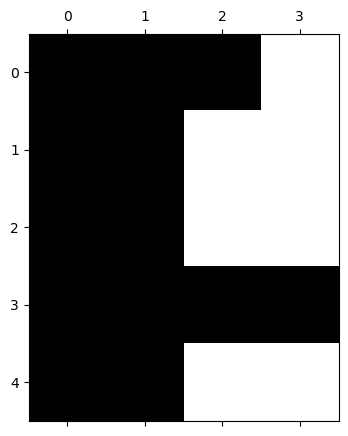

[[ 869 1360 1992  573]
 [2051 3027 2192  543]
 [1653 1083  356 4874]
 ...
 [4498 1527 3431 5053]
 [1593 2096 5060 4516]
 [1365 1776 1575 3966]] (2560, 4)


In [27]:
key = jax.random.key(0)
betas = jax.random.binomial(key, n=20, p=0.2, shape=5)
max_beta = jnp.max(betas)
all_idx = jax.random.choice(key, a=C.shape[1], shape=(C.shape[0], int(max_beta)))
mm = jnp.arange(max(betas))[None, :] < betas[:, None]
plt.matshow(mm, cmap='Greys')
plt.show()
print(all_idx, all_idx.shape)

In [4]:
aa = jnp.zeros((5, 5, 5))
aa = aa.at[1, 4, 2].set(1)
print(jnp.max(aa))

1.0


In [16]:
for i in range(5, 0, -1):
    print(i)

5
4
3
2
1


In [ ]:
# ------------------------------------------------------------------
# ScRRAMBLe connectivity with binomial sampling
# ------------------------------------------------------------------
def ScRRAMBLe_routing_optimized_v1(
    input_cores: int,
    output_cores: int,
    receptive_fields_per_capsule: int,
    connection_probability: float,
    key: jax.random.key,
    with_replacement: bool = True,
    balanced: bool = True
    ):

    """
    Returns a tensor C with shape (input_cores, total_input_slots, output_cores, total_output_slots).
    C[ci, si, co, so] can be [-2, -1, 0, 1, 2].
    1: connection to positive slots
    -1: connection to negative slots
    0: no connection
    -2: rare but repeated connection to negative slot
    2: rare but repeated connection to positive slot

    """

    # define the constants
    total_input_slots = input_cores * receptive_fields_per_capsule
    total_output_slots = output_cores * receptive_fields_per_capsule

    # define the lists of (core, slot) tuples
    Li = [(ci, si) for ci in range(input_cores) for si in range(receptive_fields_per_capsule)]
    Lo = [(co, so) for co in range(output_cores) for so in range(receptive_fields_per_capsule)]
    assert len(Li) == total_input_slots, "Incorrect number of input slots, check input_cores and slots_per_core values"
    assert len(Lo) == total_output_slots, "Incorrect number of output slots, check output_cores and slots_per_core values"

    # find the number of available receptive fields that can SEND their outputs
    num_receptive_fields = input_cores*receptive_fields_per_capsule
    
    
    # print(Li)
    # print(Lo)

    # define the positive and negative mapping dicts
    pos_mapping = defaultdict(list)
    neg_mapping = defaultdict(list)

    print("Pre positive mapping")

    # make a list of betas
    betas = jax.random.binomial(key=key, n=num_receptive_fields, p=connection_probability, shape=(len(Lo),))


    # construct the positive mapping
    for i, (co, so) in enumerate(Lo):
        # pick a random number of slots/receptive fields it can receive input from
        key, subkey = jax.random.split(key)
        # beta = jax.random.poisson(key=key, lam=avg_slot_connectivity)
        beta = int(betas[i])
        print(beta)

        # pick random slots from Li
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key=key, a=len(Li), shape=(beta,), replace=with_replacement) # allow/don't allow for repeated connections
        connections = [Li[i] for i in idx]
        if beta > 0:
            pos_mapping[(co, so)] = connections
        else:
            pos_mapping[(co, so)] = []

    print("Initialized connections")


    # print(f"Positive mapping: {pos_mapping}")

    print("Pre negative mapping")

    # construct the negative mapping
    gammas = jax.random.choice(key=key, a=receptive_fields_per_capsule, shape=(len(pos_mapping),), replace=with_replacement)

    for k, v in pos_mapping.items():
        (co, so) = k
        # check if there are any connections
        if len(v) == 0:
            continue
        else:
            # print(v, len(v))
            for idx, ti in enumerate(v):
                # print(ti)
                # choose some slots where negative connections can be made
                key, subkey = jax.random.split(key)
                gamma = int(gammas[idx])  # number of negative connections to be made
                neg_mapping[ti].append((co, gamma))

    print("Initialized negative connections")

    # print(f"Negative mapping: {neg_mapping}")

    # construct the tensor for positive mappings
    C = jnp.zeros((input_cores, receptive_fields_per_capsule, output_cores, receptive_fields_per_capsule))

    print("Initialized connectivity tensor C")

    print("Adding positive mappings to C")

    for k, v in pos_mapping.items():
        (co, so) = k

        for ti in v:
            (ci, si) = ti
            C = C.at[ci, si, co, so].add(1)

    print("Pos mappings complete!")

    print("Adding negative mappings to C")

    # construct the tensor for negative mappings
    for k, v in neg_mapping.items():
        (ci, si) = k

        if len(v) == 0:
            print(f"zero -ve mappings from core {k}")
            continue
        else:
            for to in v:
                (co, so) = to
                C = C.at[ci, si, co, so].add(-1)

    print("Neg mappings complete!")

In [10]:
rf_size= 2
core_size = 256

C = ScRRAMBLe_routing_optimized_v1(input_cores=4,
                      output_cores=50,
                      receptive_fields_per_capsule=int(core_size/rf_size),
                      connection_probability=0.5,
                      key=jax.random.key(0),
                      with_replacement=True,
                      balanced=True)
print(C.shape)
print(C)

Pre positive mapping
259
232
272
269
249
261
253
239
256
269
256
252
264
273
269
275
272
272
264
249
250


KeyboardInterrupt: 

In [2]:
# ------------------------------------------------------------------
# ScRRAMBLe connectivity with binomial sampling
# ------------------------------------------------------------------
def ScRRAMBLe_routing(
    input_cores: int,
    output_cores: int,
    receptive_fields_per_capsule: int,
    connection_probability: float,
    key: jax.random.key,
    with_replacement: bool = True,
    balanced: bool = True
    ):

    """
    Returns a tensor C with shape (input_cores, total_input_slots, output_cores, total_output_slots).
    C[ci, si, co, so] can be [-2, -1, 0, 1, 2].
    1: connection to positive slots
    -1: connection to negative slots
    0: no connection
    -2: rare but repeated connection to negative slot
    2: rare but repeated connection to positive slot

    """

    # define the constants
    total_input_slots = input_cores * receptive_fields_per_capsule
    total_output_slots = output_cores * receptive_fields_per_capsule

    # define the lists of (core, slot) tuples
    Li = [(ci, si) for ci in range(input_cores) for si in range(receptive_fields_per_capsule)]
    Lo = [(co, so) for co in range(output_cores) for so in range(receptive_fields_per_capsule)]
    assert len(Li) == total_input_slots, "Incorrect number of input slots, check input_cores and slots_per_core values"
    assert len(Lo) == total_output_slots, "Incorrect number of output slots, check output_cores and slots_per_core values"

    # find the number of available receptive fields that can SEND their outputs
    num_receptive_fields = input_cores*receptive_fields_per_capsule
    
    
    # print(Li)
    # print(Lo)

    # define the positive and negative mapping dicts
    pos_mapping = defaultdict(list)
    neg_mapping = defaultdict(list)

    print("Pre positive mapping")

    # construct the positive mapping
    for (co, so) in Lo:
        # pick a random number of slots/receptive fields it can receive input from
        key, subkey = jax.random.split(key)
        # beta = jax.random.poisson(key=key, lam=avg_slot_connectivity)
        beta = int(jax.random.binomial(key=key, n=num_receptive_fields, p=connection_probability))

        # pick random slots from Li
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key=key, a=len(Li), shape=(beta,), replace=with_replacement) # allow/don't allow for repeated connections
        connections = [Li[i] for i in idx]
        if beta > 0:
            pos_mapping[(co, so)] = connections
        else:
            pos_mapping[(co, so)] = []

    print("Initialized connections")


    # print(f"Positive mapping: {pos_mapping}")

    print("Pre negative mapping")

    # construct the negative mapping
    gammas = jax.random.choice(key=key, a=receptive_fields_per_capsule, shape=(len(pos_mapping),), replace=with_replacement)
    for k, v in pos_mapping.items():
        (co, so) = k
        # check if there are any connections
        if len(v) == 0:
            continue
        else:
            # print(v, len(v))
            for idx, ti in enumerate(v):
                # print(ti)
                # choose some slots where negative connections can be made
                key, subkey = jax.random.split(key)
                gamma = jax.random.choice(key=key, a=receptive_fields_per_capsule, shape=(1,), replace=with_replacement)[0].item()
                neg_mapping[ti].append((co, gamma))

    print("Initialized negative connections")

    # print(f"Negative mapping: {neg_mapping}")

    # construct the tensor for positive mappings
    C = jnp.zeros((input_cores, receptive_fields_per_capsule, output_cores, receptive_fields_per_capsule))

    print("Initialized connectivity tensor C")

    print("Adding positive mappings to C")

    for k, v in pos_mapping.items():
        (co, so) = k

        for ti in v:
            (ci, si) = ti
            C = C.at[ci, si, co, so].add(1)

    print("Pos mappings complete!")

    print("Adding negative mappings to C")

    # construct the tensor for negative mappings
    for k, v in neg_mapping.items():
        (ci, si) = k

        if len(v) == 0:
            print(f"zero -ve mappings from core {k}")
            continue
        else:
            for to in v:
                (co, so) = to
                C = C.at[ci, si, co, so].add(-1)

    print("Neg mappings complete!")

    def verify_connectivity(C):
        """
        Verify if the connectivity matrix makes sense
        - Each core must have equal number of positive and negative connections on an average
        - Returs a distribution of connections per core.
        - Distribution should be a delta zero with ideally no outliers
        """

        assert len(C.shape) == 4, "C must be a 4D tensor"

        balance_list = []

        # check for cores taking inputs
        for co in range(C.shape[2]):
            conn = jnp.sum(C[:, :, co, :])
            balance_list.append(conn)

        perc = jnp.percentile(a=jnp.array(balance_list), q=95)
        if perc == 0:
            pass
        else:
            raise ValueError(f"Connectivity matrix is not balanced. 95th percentile is {perc}")

    if balanced:
        verify_connectivity(C)

    return C

In [91]:
rf_size= 2
core_size = 256

C = ScRRAMBLe_routing(input_cores=20,
                      output_cores=10,
                      receptive_fields_per_capsule=int(core_size/rf_size),
                      connection_probability=0.5,
                      key=jax.random.key(0),
                      with_replacement=True,
                      balanced=True)
print(C.shape)
print(C)

KeyboardInterrupt: 

In [6]:
class ScRRAMBLeCapsLayer(nnx.Module):
    """
    Experimental Capsule module with ScRRAMBLe Routing.
    Defines a set of capsules with receptive fields.
    Routing is done through ScRRAMBLe.

    A few analogies for using intercore_connectivity function that implements ScRRAMBLe.
    1. input_cores: number of capsules needed. Calculate as (input vector size) / (capsule size).
    2. output_cores: number of capsules to be routed to. Calculate as (output vector size) / (capsule size).
    3. slots_per_core: number of receptive fields per capsule. Take as a given integer. e.g. if capsule size is 256, 4 slots_per_core would mean that each capsule has 4 receptive fields of size 64.
    4. avg_slot_connectivity: lambda parameter. Same as before. But consider connectivity to a receptive field instead of a slot. slot == receptive field in this context.
    """

    def __init__(self,
                 input_vector_size: int, # size of flattened input vector
                 num_capsules: int, # treat this as number of cores that will be used but it doesn't have to be that
                 capsule_size: int, # size of each capsule e.g. 256 (number of columns/rows of a core)
                 receptive_field_size: int, # size of each receptive field e.g. 64 (number of columns/rows of a slot)
                 connection_probability: float, # fraction of total receptive fields on sender side that each receiving slot/receptive field takes input from
                 rngs: nnx.Rngs
                 ):
        
        self.input_vector_size = input_vector_size
        self.num_capsules = num_capsules
        self.capsule_size = capsule_size
        self.receptive_field_size = receptive_field_size
        self.rngs = rngs
        self.connection_probability = connection_probability

        # compute the number of receptive fields per capsule
        self.receptive_fields_per_capsule = math.ceil(self.capsule_size / self.receptive_field_size) # rounded up to the nearest integer

        # compute number of effective capsules coming from the input vector
        self.input_eff_capsules = math.ceil(self.input_vector_size / self.capsule_size) # rounded up to the nearest integer

        # initialize the ScRRAMBLe connectivity matrix
        # Ci = intercore_connectivity(
        #     input_cores=self.input_eff_capsules,
        #     output_cores=self.num_capsules,
        #     slots_per_core=self.receptive_fields_per_capsule,
        #     avg_slot_connectivity=self.avg_receptive_field_connectivity,
        #     key=self.rngs.params()
        # ) 

        print(f"Pre C tensor initialization, num_cores={num_capsules}, proba = {connection_probability}")

        Ci = ScRRAMBLe_routing(
            input_cores=self.input_eff_capsules,
            output_cores=self.num_capsules,
            receptive_fields_per_capsule= self.receptive_fields_per_capsule,
            connection_probability=self.connection_probability,
            key=self.rngs.params(),
            with_replacement=True
        )

        print("Loaded connectivity tensor")

        self.Ci = nnx.Variable(Ci)

        # initialize the weights on the capsules
        initializer = initializers.glorot_normal()
        self.Wi = nnx.Param(initializer(self.rngs.params(), (self.num_capsules, self.receptive_fields_per_capsule, self.receptive_fields_per_capsule, self.receptive_field_size, self.receptive_field_size))) # e.g. (10, 4, 4, 64, 64)
        print("Initialized capsule weights")

    def __call__(self, x: jax.Array) -> jax.Array:
        """
        Forward pass through the capsule layer with ScRRAMBLe routing
        Args:
        x: jax.Array. flattened input, No batch dimension. Shape should be (input_vector_size,). e.g. (1000,)
        """

        # pad the input with zeros if the length is not a multiple of capsule size
        if x.shape[0]%self.capsule_size != 0:
            x_padded = jnp.pad(x, (0, self.input_eff_capsules*self.capsule_size - x.shape[0]), mode='constant', constant_values=0)
        else:
            x_padded = x
        
        # reshape input into (input_eff_capsules, receptive_fields_per_capsule, receptive_field_size)
        x_reshaped = x_padded.reshape(self.input_eff_capsules, self.receptive_fields_per_capsule, self.receptive_field_size)

        # ScRRAMBLe Routing to the cores
        x_routed = jnp.einsum('ijkl,ijm->klm', self.Ci, x_reshaped)

        y = jnp.einsum('ijklm,ikm->ijl', self.Wi, x_routed)

        return y

    # visualizing connectivity
    def visualize_connectivity(self) -> jax.Array:
        """
        Function returns a jax.Array Wc describing connectivity between neurons in one layer of the network.
        Args:
        1. learned_capsule_weights: jax.Array: Make sure that the shape is (self.Wi.shape[0], self.receptive_fields_per_capsule, self.receptive_fields_per_capsule, self.receptive_field_size, self.receptive_field_size) (5D tensor)
        2. Routing matrix: taken from the intercore_connectivity function. The shape should be (output cores, output slots, input cores, input slots)

        Returns:
        Wc: jax.Array of shape (num output neurons, num input neurons) where Wc[i, j] is the weight from input neuron j to output neuron i.
        """

        # find number of neurons
        num_output_neurons = self.num_capsules * self.capsule_size
        num_input_neurons = self.input_eff_capsules * self.capsule_size

        # initialize the giant connectivity matrix
        Wc = jnp.zeros((num_output_neurons, num_input_neurons))

        # set up for loops
        for co in range(self.num_capsules):
            for so in range(self.receptive_fields_per_capsule):
                for ci in range(self.input_eff_capsules):
                    for si in range(self.receptive_fields_per_capsule):
                        # print(f"co = {co}, so = {so}, ci = {ci}, si = {si}")
                        # get routing weight
                        r = float(self.Ci[co, so, ci, si])

                        if r == 0:
                            continue
                        else:
                            W_dense = r*self.Wi[co, so , si, :, :]
                            # print(W_dense.shape)
                            # print(co*self.capsule_size + so*self.receptive_field_size)
                            # print(co*self.capsule_size + (so+1)*self.receptive_field_size)
                            # print(self.capsule_size*ci + self.receptive_field_size*si)
                            # print(self.capsule_size*ci + (si+1)*self.receptive_field_size)
                            # print(Wc[(co*self.capsule_size + so*self.receptive_field_size):(co*self.capsule_size + (so+1)*self.receptive_field_size), (self.capsule_size*ci + self.receptive_field_size*si):(self.capsule_size*ci + (si+1)*self.receptive_field_size)].shape)

                            Wc = Wc.at[(co*self.capsule_size + so*self.receptive_field_size):(co*self.capsule_size + (so+1)*self.receptive_field_size), (self.capsule_size*ci + self.receptive_field_size*si):(self.capsule_size*ci + (si+1)*self.receptive_field_size)].set(W_dense)

        return Wc



# if __name__ == "__main__":
#     __main__()


In [7]:
# -------------------------------------------------------------------
# Define the Reconstruction network
# -------------------------------------------------------------------
class ReconstructionNetwork(nnx.Module):
    def __init__(self,
                 input_size: int,
                 rngs: nnx.Rngs):
        
        # define feedforward layers
        self.fc1 = nnx.Linear(input_size, 5000, rngs=rngs)
        self.fc2 = nnx.Linear(5000, 3000, rngs=rngs)
        self.fc3 = nnx.Linear(3000, 28*28, rngs=rngs)

    def __call__(self, x):

        x = nnx.relu(self.fc1(x))
        x = nnx.relu(self.fc2(x))
        x = nnx.sigmoid(self.fc3(x))

        return x


# -------------------------------------------------------------------
# Define the MNIST CapsNet Model
# -------------------------------------------------------------------
class ScRRAMBLeCapsNetWithReconstruction(nnx.Module):
    """
    ScRRAMBLe CapsNet model for MNIST classification.

    Notes:
    - Currently assumes that the connection probability is the same for all the layers.
    """

    def __init__(
            self,
            input_vector_size: int, # size of flattened input vector
            capsule_size: int, # size of each capsule e.g. 256 (number of columns/rows of a core)
            receptive_field_size: int, # size of each receptive field e.g. 64 (number of columns/rows of a slot)
            connection_probability: float, # fraction of total receptive fields on sender side that each receiving slot/receptive field takes input from
            rngs: nnx.Rngs,
            layer_sizes: list = [20, 10, 10], # number of capsules in each layer of the capsnet. e.g. [20, 10] means 20 capsules in layer 1 and 10 capsules in layer 2
            activation_function: Callable = nnx.relu, # activation function to use in the network
    ):
        
        self.input_vector_size = input_vector_size
        self.capsule_size = capsule_size 
        self.receptive_field_size = receptive_field_size
        self.rngs = rngs
        self.connection_probability = connection_probability
        self.layer_sizes = layer_sizes
        self.activation_function = activation_function

        # calculate the effective capsules in input vector rouded to the nearest integral multiple of capsule size
        self.input_eff_capsules = math.ceil(self.input_vector_size/self.capsule_size)

        # add this element as the first element of layer_sizes
        self.layer_sizes.insert(0, self.input_eff_capsules)

        # define ScRRAMBLe capsules
        self.scrramble_caps_layers = [ScRRAMBLeCapsLayer(
            input_vector_size=self.capsule_size * Nci,
            num_capsules=Nco,
            capsule_size=self.capsule_size,
            receptive_field_size=self.receptive_field_size,
            connection_probability=self.connection_probability,
            rngs=self.rngs
        ) for Nci, Nco in zip(self.layer_sizes[:-1], self.layer_sizes[1:])]

        # define the reconstruction network
        self.reconstruction_nw = ReconstructionNetwork(
            input_size=self.capsule_size * self.layer_sizes[-1],  # Input size
            rngs=self.rngs
        )


    def __call__(self, x:jax.Array) -> jax.Array:
        """
        Forward pass through the ScRRAMBLe CapsNet
        """

        # resize the image to be (32, 32) for MNIST
        x = jax.image.resize(x, (x.shape[0], 32, 32, 1), method='nearest')

        # flatten the first two dimensions
        x = jnp.reshape(x, (x.shape[0], -1))

        # pass the input through the layers
        for layer in self.scrramble_caps_layers:
            x = jax.vmap(layer, in_axes=(0,))(x)
            x = jnp.reshape(x, (x.shape[0], -1))
            shape_x = x.shape
            # x = x.flatten()
            # x = jax.vmap(self.activation_function, in_axes=(0, None, None))(x, 8, 1.0) # 8 bits, 1.0 is the max clipping threshold.
            # x = self.activation_function(x)  # Apply the activation function.
            x = jax.vmap(self.activation_function, in_axes=(0,))(x)  # Apply the activation function.
            x = jnp.reshape(x, shape_x)

        # add the reconstruction network
        x_recon = x.reshape((x.shape[0], -1))  # Flatten the output for reconstruction.
        x_recon = jax.vmap(self.reconstruction_nw, in_axes=(0,))(x_recon)  # Apply the reconstruction network.


        return x_recon, x
    

# # testing
# def __main__():
#     key = jax.random.key(10)
#     key1, key2, key3, key4 = jax.random.split(key, 4)
#     rngs = nnx.Rngs(params=key1, activations=key2, permute=key3, default=key4)

#     model = ScRRAMBLeCapsNetWithReconstruction(
#         input_vector_size=1024,
#         capsule_size=256,
#         receptive_field_size=64,
#         connection_probability=0.2,
#         rngs=rngs,
#         layer_sizes=[50, 10],  # 20 capsules in the first layer and (translates to sum of layer_sizes cores total)
#         activation_function=nnx.relu
#     )

#     # dummy input
#     x_test = jax.random.normal(rngs.default(), (10, 28, 28, 1))
#     recon, caps_out = model(x_test)
#     print("Reconstruction shape:", recon.shape)
#     print("Capsule output shape:", caps_out.shape)

# if __name__ == "__main__":
#     __main__()


In [10]:
def load_model(rf_size=64, p=0.2):
    rngs = nnx.Rngs(default=0, permute=1, activation=2)
    model = ScRRAMBLeCapsNetWithReconstruction(
                            input_vector_size=1024,
                            capsule_size=256,
                            receptive_field_size=rf_size,
                            connection_probability=p,
                            rngs=rngs,
                            layer_sizes=[50, 10],  # 60 capsules total
                            activation_function=nnx.relu
                            )
    
    return model

loading_time = timeit.timeit(lambda: load_model(rf_size=64, p=0.2), number=1)

print("--"*50)
print(f"Model loading time: {loading_time:.4f} seconds")
print("Model loaded successfully.")

Pre C tensor initialization, num_cores=50, proba = 0.2
Pre positive mapping
Initialized connections
Pre negative mapping
Initialized negative connections
Initialized connectivity tensor C
Adding positive mappings to C
Pos mappings complete!
Adding negative mappings to C
Neg mappings complete!
Loaded connectivity tensor
Initialized capsule weights
Pre C tensor initialization, num_cores=10, proba = 0.2
Pre positive mapping
Initialized connections
Pre negative mapping
Initialized negative connections
Initialized connectivity tensor C
Adding positive mappings to C
Pos mappings complete!
Adding negative mappings to C
Neg mappings complete!
Loaded connectivity tensor
Initialized capsule weights
----------------------------------------------------------------------------------------------------
Model loading time: 20.6154 seconds
Model loaded successfully.


In [24]:
xx = jnp.zeros((4, 10, 4, 10))
l1 = [1, 3, 5, 6]
l2 = [2, 5, 6, 7]

xx = xx.at[:, :, l1, l2].add(1)
# xx = xx.at[:, 1:3].add(-1)

xx

Array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0.

In [27]:
key = jax.random.key(0)
jax.random.choice(key=key, a=10, shape=(4,), replace=True)[1]

Array(0, dtype=int32)

In [1]:
rf_sizes = jnp.logspace(0, 8, 9, base=2).astype(int).tolist()
rf_sizes

NameError: name 'jnp' is not defined